In [4]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr

# Ilan
from icecream import ic
import nc_time_axis

def worldmap(var, title='', cbar_title='', **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()
    ax.set_title(title)

    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8, label=cbar_title)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    
def usmap(var, title='', cbar_title='', **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    #projection = ccrs.Robinson(central_longitude=-90)
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(
        figsize=(6, 3), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_extent([-130, -60, 20, 45])
    
    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.7, label=cbar_title)
    ax.set_title(title)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    #ax.coastlines(linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    ax.add_feature(cf.STATES, linewidth=0.4)

In [2]:
# set up dask
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
# cluster = LocalCluster()
# client = Client(cluster)
# client

In [3]:
# catfn='/home/tmerlis/hackathon/xsh24_scream_main.yaml'
catfn='/home/tmerlis/hackathon/hackathon_cat_may14_main.yaml'

combo_cat = intake.open_catalog(catfn)

# 'coarse' is an online coarse-graining of 8 neighboring grid cells ~25km
# xsh24 = X-SHiELD 2024 model version, unpublished
# xsh21 = X-SHiELD 2021 model version, many articles including Cheng et al. 2022 GRL
print (list(combo_cat)) 

['xsh24_coarse', 'xsh24_native', 'xsh21_coarse', 'scream2D_hrly', 'scream_ne120', 'scream_lnd', 'ifs_fesom', 'icon_3hp003']


In [4]:
def preprocess(ds):
    res = ds \
        .assign(wind=lambda x: np.sqrt(x['ua']**2 + x['va']**2)) \
        .assign(height=lambda x: x['zg']) # geopotential height (basically height)
    return res
    
# select zoom level and the part of the combined catalog you're interested in
# coarse stores are available at zoom 7 ~50km and lower
zoom_select = 7 # Wind speeds are messed up for zoom 7 and less
ds = combo_cat.xsh24_coarse(zoom=zoom_select).to_dask().drop_vars('cell')
# attach coordinates; otherwise can't use lat and lon and selecting regions or taking a zonal mean won't work
ds = ds.pipe(egh.attach_coords).pipe(preprocess)

# we downloaded output from DOE's SCREAM model to stellar
# conceivably, we could add to our local collection of models during the week
# or augment the catalog with observational datasets
ds_scream = combo_cat.scream_ne120(zoom=zoom_select).to_dask()
ds_scream = ds_scream.pipe(egh.attach_coords)
ds

/home/iv4111/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


[########################################] | 100% Completed | 100.81 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 101.07 ms
[########################################] | 100% Completed | 101.14 ms
[########################################] | 100% Completed | 101.10 ms
[########################################] | 100% Completed | 101.11 ms


/home/iv4111/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 1TB
Dimensions:  (time: 3560, cell: 196608, plev: 31, pfull: 79)
Coordinates:
  * pfull    (pfull) float32 316B 4.514 8.301 12.45 16.74 ... 989.5 994.3 998.3
  * plev     (plev) float32 124B 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * time     (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-07 00:00:00
    crs      int64 8B 0
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
Data variables: (12/40)
    clivi    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    clt      (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    clwvi    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    hflsd    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    hfssd    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    hur      (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    ...       ...
    vas      (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    wa       (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    wap      (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    zg       (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    wind     (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    height   (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>

[########################################] | 100% Completed | 2.41 sms


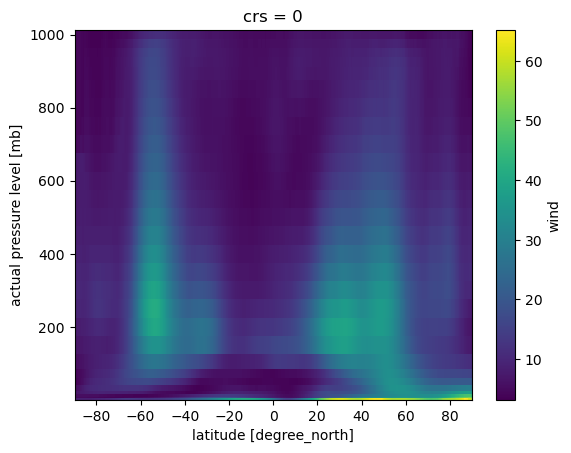

In [5]:
ds.wind.sel(time=slice('2021-01-01', '2021-02-01')).mean('time').groupby('lat').mean().plot()

[########################################] | 100% Completed | 204.55 ms


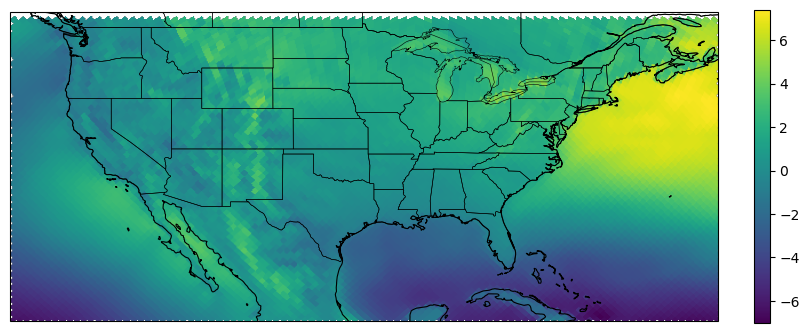

In [6]:
# Select the GPPLJ regions
us = ((ds.lat <= 50) & (ds.lat >= 20) & (ds.lon >= -130+360) & (ds.lon <= -60+360))
ds_us = ds.isel(cell=us)
usmap(ds_us.uas.sel(time=slice('2020-01-01', '2020-02-01')).mean('time'))

## Detection algorithm

Based on 
 >Luiz, E. W., & Fiedler, S. (2024). Global climatology of low‐level‐jets: Occurrence, characteristics, and meteorological drivers. Journal of Geophysical Research: Atmospheres, 129(9), e2023JD040262.

which adapted an algorithm created by 
> Fiedler, S., Schepanski, K., Heinold, B., Knippertz, P., & Tegen, I. (2013). Climatology of nocturnal low‐level jets over North Africa and implications for modeling mineral dust emission. Journal of Geophysical Research: Atmospheres, 118(12), 6100-6121.

### Algorithm
1. Core must be in the lowest 1,000 m
2. Vertical shear more negative than 0.005 s$^{-1}$ in the 500 m deep layer above the LLJ core
3. Difference between same layers of 2 m s$^{-1}$

Additional criteria added by us:

- Jet speed $\geq$ 10 m s$^{-1}$
- Jet height $\geq$ 50 m (prevents max at 10 m from being detected)

Nuanced difference -> the shear is done using differentiation

In [ ]:
### Old -> not the best
# Get the lowest 1.5 km of the atmosphere (jet can be max 1 km)
low = xr.where((ds_us.height <= 1500) & (ds_us.height>=0), ds_us[['wind', 'height']], np.nan).chunk({'plev': -1})

def get_lljs(wind, height, plev):
    """
    Input: one cell of data, dim is [plev]
    Output: dataset with 3 fields
        1. mask [time, cell] -> True for jet, False for no
        2. height [time, cell] -> height of the LLJ [m] (will always have data)
        2. strength [time, cell] -> strength of the jet core [m/s] (will always have data)

    Big problems:
        1. Jet can only be detected on fixed geopotential heights
    """
    # Get the pressure of the core
    try:
        core_idx = np.nanargmax(wind)
    except ValueError: # all NaN slice
        return (False, np.nan, np.nan)
    core_layer = wind[core_idx]
    good_wind = core_layer >= 10
    # Check for fast wind
    if not good_wind:
        return (False, np.nan, np.nan)
    core_height = height[core_idx]
    if not core_height <= 1000: # will lead to index error
        return (False, np.nan, np.nan)
    buffer_500m = core_height + 500
    # Get the index of the closest height
    buffer_idx = np.nanargmin(height-buffer_500m) # height is everywhere, buffer is not
    buffer_plev = plev[buffer_idx]
    # Get core and top layer
    top_layer = wind[buffer_idx]
    # Get shear
    shear = np.gradient(wind, heights)[buffer_idx]
    # Perform checks
    wind_diff = core_layer - top_layer
    good_diff = wind_diff > 2
    good_shear = shear < 0.005
    jet = (good_height & good_diff & good_shear & good_wind)
    if jet:
        return (jet, core_height, core_layer)
    else:
        return (False, np.nan, np.nan)

In [7]:
def get_lljs(c_winds, c_heights):
    """
    Input: one cell of data, dim is [plev]
    Output: dataset with 3 fields
        1. mask [time, cell] -> True for jet, False for no
        2. height [time, cell] -> height of the LLJ [m] (will always have data)
        2. strength [time, cell] -> strength of the jet core [m/s] (will always have data)
    """
    # Need increasing heights for np.interp to work
    good_heights = c_heights >= 0
    c_heights, c_winds = c_heights[good_heights], c_winds[good_heights]
    sort_idx = np.argsort(c_heights)
    c_heights, c_winds = c_heights[sort_idx], c_winds[sort_idx]
    # Step 1 -> interpolate winds to specific height levels
    heights = np.arange(10, 3010, 10) # 100m threshold
    winds = np.interp(heights, c_heights, c_winds)
    core_idx = np.nanargmax(winds)
    # Get core properties
    core_height = heights[core_idx]
    if core_height > 1000: # will lead to index error
        return (0, np.nan, np.nan)
    core_speed = winds[core_idx]
    # Get layer properties
    buffer_idx = core_idx + 50 # 500 m buffer @ 10 m spacing
    buffer_speed = winds[buffer_idx]
    shear = np.gradient(winds, 10)[buffer_idx]
    # Checks
    jet = ((core_speed - buffer_speed) > 2) \
        & (core_height <= 1000) \
        & (core_height >= 50) \
        & (core_speed >= 10) \
        & (shear < 0.005)
    if jet:
        return (1, core_height, core_speed)
    else:
        return (0, np.nan, np.nan)

def apply_lljs(wind, height):
    jet_mask, jet_height, jet_speed = xr.apply_ufunc(
        get_lljs,
        wind.chunk({'plev':-1}),
        height.chunk({'plev':-1}),
        input_core_dims=[["plev"], ["plev"]],
        output_core_dims=[[], [], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[bool, float, float],
    )
    return xr.merge([
        jet_mask.rename('mask'),
        jet_height.rename('height'), 
        jet_speed.rename('speed')
    ])

In [8]:
# Save full X-Shield data
wind = ds_us.wind
height = ds_us.height
llj = apply_lljs(wind, height).compute()
llj['crs'].attrs = ds_us['crs'].attrs.copy() # need to copy attributes so healpix doesn't mess up
llj.to_netcdf("/scratch/cimes/iv4111/hk25-data/llj_XSHIELD.h5")

[########################################] | 100% Completed | 19m 50s


In [2]:
llj = xr.open_dataset("/scratch/cimes/iv4111/hk25-data/llj_XSHIELD.h5")
llj

<xarray.Dataset> Size: 490MB
Dimensions:  (time: 3560, cell: 8096)
Coordinates:
  * time     (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-07 00:00:00
    crs      int64 8B ...
  * cell     (cell) int64 65kB 34141 34142 34143 34157 ... 131069 131070 131071
    lat      (cell) float64 65kB ...
    lon      (cell) float64 65kB ...
Data variables:
    mask     (time, cell) bool 29MB ...
    height   (time, cell) float64 231MB ...
    speed    (time, cell) float64 231MB ...

In [5]:
# Frequency
freq = llj.mask.sum('time')/len(llj.time)*100
### Only select regions where they occur >5% of the time ###
freq = freq.where(freq>5, np.nan)
llj = llj.where(freq>5, np.nan)
title = 'X-Shield (2019-10-20 to 2021-1-7)' ### THESE DATES MAY BE WRONG ###
usmap(freq, title=f'LLJ Occurrence {title}', cbar_title='Frequency [%]', vmin=5)
plt.savefig('figures/occurence_XSHIELD.jpg', dpi=300)
plt.close()
# Speed
usmap(llj.speed.mean('time'), title=f'LLJ Speed {title}', cbar_title=r'Mean Speed of LLJ [m s$^{-1}$]', cmap='Reds')
plt.savefig('figures/speed_XSHIELD.jpg', dpi=300)
plt.close()
# Jet height
usmap(llj.height.mean('time'), title=f'LLJ Height {title}', cbar_title=r'Mean Height of LLJ [m]', cmap='Blues')
plt.savefig('figures/height_XSHIELD.jpg', dpi=300)
plt.close()

## Now save global data

In [ ]:
g_low = xr.where((ds.height <= 1500) & (ds.height>=0), ds[['wind', 'height']], np.nan) \
    .dropna('cell', how='all') \
    .chunk({'plev': -1})
    # .dropna('plev', how='all') \
# Drop nan slices
# g_llj = apply_lljs(g_low.wind, g_low.height, g_low.plev)
# g_llj['crs'].attrs = ds['crs'].attrs.copy() # need to copy attributes so healpix doesn't mess up
# g_llj.to_netcdf("/scratch/cimes/iv4111/hk25-data/llj_GLOBAL.h5")

In [ ]:
g_low.wind

In [ ]:
freq = g_llj.mask.sum('time')/len(g_llj.time)*100
freq = freq.where(freq>0, np.nan)
title = 'X-Shield (TBD to TBD)'
worldmap(freq, title=f'LLJ Occurrence {title}', cbar_title='Frequency [%]', vmin=0)
# Speed
worldmap(g_llj.speed.mean('time', skipna=True), title=f'LLJ Speed {title}', cbar_title=r'Mean Speed of LLJ [m s$^{-1}$]', vmin=0, cmap='plasma')
# Jet height
worldmap(g_llj.height.mean('time'), title=f'LLJ Height {title}', cbar_title=r'Mean Height of LLJ [m]', vmin=0, cmap='cividis')

## Shut down Dask cluster

In [ ]:
client.shutdown()